# Advanced exercise 4

This exercise is a more advanced exercise in the Python for Scientists course. 
Its goal is to prepare you for the practical exam.

On the practical exam, you will get two or three problems of a similar difficulty as this one. 
The practical exam consists of two parts:
- **The coding part**: During this part you will have to write code on your own laptop to solve a few problems (usually rooted in physics). This part is open book and open internet (usage of AI tools is allowed).
- **The insights part**: during this part you will have to answer a few questions (on paper) related to the programming exercises from the previous part. You are not allowed to use your laptop or the course material for this part. The questions will test your insight in the solution of the coding part.

In this notebook, both parts are combined. 
You can use AI tools for coding, but try to answer the insights questions on your own, since this will also be the situation during the exam.

If you have questions or if you are stuck, don't hesitate to ask for help (either during class or through e-mail (jorden.debolle@ugent.be))

Good luck!


In [10]:
# If you need to import (from) more modules, add import lines to this cell.
# ...
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, identity
from scipy.sparse.linalg import eigsh  # sparse Hermitian eigensolver
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

## Quantum particle in a 2D box

In quantum mechanics, the 2D time independent Schrödinger equation (TISE) is used to calculate the energy levels of a particle in stationary problems. 
The time independent Schrödinger equation is given by (using natural units with $\hbar=1$ and a particle of unit mass): 
\begin{equation}
-\left(\frac{\partial^2\psi(x,y)}{\partial x^2} + \frac{\partial^2\psi(x,y)}{\partial y^2}\right) + V(x, y)\psi(x,y) = E\psi(x,y)
\end{equation}
Here, $\psi(x,y)$ is the wave function of the particle, $E$ is the total energy of the particle, and $V(x,y)$ is the potential. 
This is an eigenvalue equation, with the discrete energy levels E as eigenvalues. 
The probability density function, that gives you the probability of finding the particle at a certain location, is given by $\|\psi\|^2 = \psi(x,y) \times \psi(x,y)^*$ (where $\psi^*$ is the complex conjugate of $\psi$).

In this exercise, your goal is to numerically solve the TISE, assuming a particle in a 2D box of size $1 \times 1$. This means that:
$$
\left\lbrace\begin{aligned}
        V(x,y) &= 0
        \quad \text{inside the box, so for } 0<x<1 \text{ and } 0<y<1
        \\
        V(x,y) &= \infty
        \quad \text{outside the box so for } x \le 0 \text{ and } x \ge 1 \text{ and } y \le 0 \text{ and } y \ge 1 
        \end{aligned}\right.
$$
and the TISE reduces to 
\begin{equation}
-\left(\frac{\partial^2\psi(x,y)}{\partial x^2} + \frac{\partial^2\psi(x,y)}{\partial y^2}\right) = E\psi(x,y)
\end{equation}
This is a partial differential equation that looks very much like the Laplace equation, but with a non-zero right-hand side. 
The infinite potential means that $\psi(x,y)=0$ outside the box and on the edges of the box, which can be used as boundary condition.

Discretise the equation using a centered difference approximation for a 20x20 grid and solve for the eigenvalues and eigenvectors. The eigenvectors represent the eigenfunctions $\psi(x,y)$. Calculate the probability density functions $\psi(x,y) \times \psi(x,y)^*$. 

### Step 1: Discretisation and solution of the TISE

**Q1.** Discretise the equation using a centered difference approximation for a 20x20 grid and solve for the eigenvalues and eigenvectors. 
The eigenvectors represent the eigenfunctions $\psi(x,y)$. 
Calculate the probability density functions $\psi(x,y) \times \psi^*(x,y)$.  


(Beetje de ladder operators van in kwantum lessen.)

Lowest energies:
n=0: E ≈ 19.70242
n=1: E ≈ 49.03600
n=2: E ≈ 49.03600
n=3: E ≈ 78.36957
n=4: E ≈ 97.19667
n=5: E ≈ 97.19667
n=6: E ≈ 126.53024
n=7: E ≈ 126.53024
n=8: E ≈ 163.10861


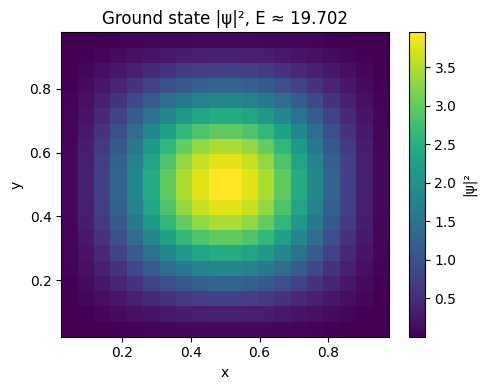

In [11]:
import numpy as np
from scipy.sparse import diags, kron, identity
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# --- Parameters ---
N = 20          # number of interior grid points in x and y
L = 1.0
h = L / (N + 1) # grid spacing

# --- 1D operator for -d^2/dx^2 with Dirichlet BC ---
main = 2.0 * np.ones(N)
off  = -1.0 * np.ones(N - 1)

T = diags([off, main, off], offsets=[-1, 0, 1]) / h**2
I = identity(N)

# --- 2D operator: -∇^2 = I⊗T + T⊗I (V=0 in the box) ---
H = kron(I, T) + kron(T, I)   # size: (N^2, N^2)

# --- Solve eigenvalue problem H ψ = E ψ (lowest few) ---
num_eigs = 9
E, vecs = eigsh(H, k=num_eigs, which="SM")  # "SM" = smallest magnitude eigenvalues

# Sort them
idx = np.argsort(E)
E = E[idx]
vecs = vecs[:, idx]

print("Lowest energies:")
for n, En in enumerate(E):
    print(f"n={n}: E ≈ {En:.5f}")


def to_grid_and_normalize(vec, N, h):
    """
    Reshape eigenvector (length N^2) to an (N,N) grid and normalize
    so that sum |psi|^2 h^2 = 1.
    """
    psi = vec.reshape((N, N))
    norm2 = np.sum(np.abs(psi)**2) * h**2
    psi /= np.sqrt(norm2)
    return psi


# --- Compute eigenfunctions ψ_n(x_i,y_j) and probability densities |ψ|^2 ---
psis = []
rhos = []

for n in range(num_eigs):
    psi_n = to_grid_and_normalize(vecs[:, n], N, h)
    rho_n = np.abs(psi_n)**2          # probability density ψ ψ*
    psis.append(psi_n)
    rhos.append(rho_n)

# Example: plot ground state probability density
x = np.linspace(h, 1.0 - h, N)
y = np.linspace(h, 1.0 - h, N)
X, Y = np.meshgrid(x, y, indexing="ij")

plt.figure(figsize=(5, 4))
plt.pcolormesh(X, Y, rhos[0], shading="auto")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Ground state |ψ|², E ≈ {E[0]:.3f}")
plt.colorbar(label="|ψ|²")
plt.tight_layout()
plt.show()



### Step 2: Exact analytical solution of the TISE

For this particular problem, there is an exact analytical solution for the energy eigenvalues and the wave functions:
\begin{equation}
E_{k,j} = (k^2+j^2)\pi^2
\end{equation}

\begin{equation}
\psi_{k,j}(x,y) = \sin(k \pi x) \sin(j \pi y) 
\end{equation}

\begin{equation}
\text{for } k,j = 1,2,3,\text{...}
\end{equation}

**Q2.** Implement functions that return these exact solutions.

In [12]:
# Q2: exact analytical energies and wavefunctions

def exact_energy(k, j):
    """
    Exact analytical energy for the 2D infinite square well:
        E_{k,j} = (k^2 + j^2) * pi^2
    with k, j = 1, 2, 3, ...
    """
    return (k**2 + j**2) * np.pi**2


def exact_wavefunction(k, j, x, y):
    """
    Exact analytical wavefunction for the 2D infinite square well:
        psi_{k,j}(x,y) = sin(k*pi*x) * sin(j*pi*y)

    Parameters
    ----------
    k, j : int
        Quantum numbers (positive integers).
    x, y : float or np.ndarray
        Coordinates where the wavefunction is evaluated.
        x and y can be scalars or arrays; broadcasting is supported.

    Returns
    -------
    psi : float or np.ndarray
        Value of psi_{k,j}(x,y) at the given coordinates.
    """
    return np.sin(k * np.pi * x) * np.sin(j * np.pi * y)


### Step 3: Comparison of analytical and numerical solution

**Q3.** Plot the eigenvalues you found together with the exact eigenvalues. Make sure you sort them before plotting. Make a clean plot. Zoom in on the first 100 values.

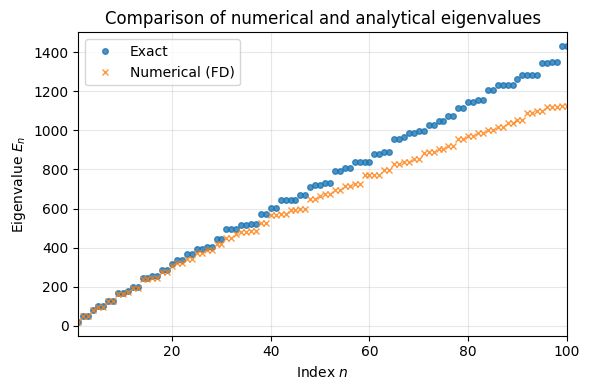

In [13]:
# Implement your solution to Q3. here
# aantal eigenwaarden dat we willen vergelijken
num_eigs_q3 = 100

# --- numerieke eigenwaarden (Matrix A komt uit Q1) ---
E_num, _ = eigsh(A, k=num_eigs_q3, which="SM")  # smallest magnitude eigenvalues
E_num = np.sort(E_num)

# --- analytische eigenwaarden E_{k,j} = (k^2 + j^2) * pi^2 ---
E_exact_all = []
for k in range(1, N + 1):
    for j in range(1, N + 1):
        E_exact_all.append(exact_energy(k, j))   # uit Q2

E_exact_all = np.sort(np.array(E_exact_all))
E_exact = E_exact_all[:num_eigs_q3]             # eerste 100 exacte waarden

# index n = 1, ..., 100
n = np.arange(1, num_eigs_q3 + 1)

# --- plot ---
plt.figure(figsize=(6, 4))

plt.plot(n, E_exact, "o", markersize=4, label="Exact", alpha=0.8)
plt.plot(n, E_num, "x", markersize=4, label="Numerical (FD)", alpha=0.8)

plt.xlabel("Index $n$")
plt.ylabel("Eigenvalue $E_n$")
plt.title("Comparison of numerical and analytical eigenvalues")
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom in on the first 100 values (x-as is sowieso 1..100, maar expliciet zetten kan geen kwaad)
plt.xlim(1, num_eigs_q3)

plt.tight_layout()
plt.show()


**Q4.** Make 2D colorplots of the probability density functions $\|\psi(x,y)\|^2$ you found corresponding the the 4 lowest eigenvalues, and also their analytical counterparts. The analytical eigenfunctions you need for this correspond to k,j=(1,1), (1,2), (2,1) and (2,2). Make sure all probability density functions are normalised by subtracting their minimal value and then dividing by their maximal value, such that the analytical and numerical solutions are shown on the same color scale.

In [15]:
Nx = Ny = 20
hx = 1.0 / (Nx + 1)
hy = hx  # square box
N = Nx * Ny

# 1D Laplacian with Dirichlet BC
main = -2.0 * np.ones(Nx)
off = 1.0 * np.ones(Nx - 1)
L1d = sp.diags([off, main, off], [-1, 0, 1], format="csr")

Ix = sp.eye(Nx, format="csr")
Iy = sp.eye(Ny, format="csr")

# 2D Laplacian (5-point stencil)
L2d = sp.kron(Iy, L1d) + sp.kron(L1d, Ix)

# Hamiltonian H = -∇²
H = -L2d / (hx * hx)

# lowest few numerical eigenpairs
neig = 16
E_num, psi_vecs = spla.eigsh(H, k=neig, which="SM")
order = np.argsort(E_num)
E_num = E_num[order]
psi_vecs = psi_vecs[:, order]

# grid for analytic wavefunctions
x = np.linspace(hx, 1.0 - hx, Nx)
y = np.linspace(hy, 1.0 - hy, Ny)
X, Y = np.meshgrid(x, y)  # shape (Ny, Nx)

def exact_energy(nx, ny):
    """Analytic energies for the 2D infinite well on [0,1]x[0,1]."""
    return np.pi**2 * (nx**2 + ny**2)


def exact_wavefunction(nx, ny, X, Y):
    """Analytic eigenfunction ψ_{nx,ny}(x,y) (continuous, normalized)."""
    psi = 2.0 * np.sin(nx * np.pi * X) * np.sin(ny * np.pi * Y)
    return psi


In [18]:
def compare_wavefunctions():
    """
    For a few low-lying states (nx, ny), compare numerical and analytic
    eigenfunctions: overlap and relative L2 error.
    """
    # choose some low-lying analytic states in increasing energy
    states = [(1, 1), (1, 2), (2, 1), (2, 2),
              (1, 3), (3, 1), (2, 3), (3, 2)]
    E_exact_list = np.array([exact_energy(nx, ny) for (nx, ny) in states])

    print("State  (nx,ny) | E_exact   | E_num     | overlap  | rel_L2_error")
    print("-----------------------------------------------------------------")

    for (nx, ny), Eex in zip(states, E_exact_list):
        # index of the numerical eigenvalue closest to E_exact
        k = np.argmin(np.abs(E_num - Eex))

        psi_num = psi_vecs[:, k].reshape(Ny, Nx)
        # normalize numerically
        psi_num = psi_num / np.linalg.norm(psi_num.ravel())

        psi_ex = exact_wavefunction(nx, ny, X, Y)
        psi_ex = psi_ex / np.linalg.norm(psi_ex.ravel())

        # fix global sign to maximize overlap
        phase = np.sign(np.vdot(psi_ex.ravel(), psi_num.ravel()))
        if phase == 0:
            phase = 1.0
        psi_num *= phase

        overlap = np.vdot(psi_ex.ravel(), psi_num.ravel()).real
        rel_err = (
            np.linalg.norm(psi_num.ravel() - psi_ex.ravel())
            / np.linalg.norm(psi_ex.ravel())
        )

        print(
            f"{(nx,ny)!s:>11} | {Eex:8.4f} | {E_num[k]:8.4f} | "
            f"{overlap:7.4f} | {rel_err:11.4e}"
        )


# optional visualization helper (can be called manually)
def plot_wavefunction_pair(nx=1, ny=1):
    """
    Plot |ψ_num|^2 and |ψ_exact|^2 for one chosen state (nx, ny).
    """
    Eex = exact_energy(nx, ny)
    k = np.argmin(np.abs(E_num - Eex))

    psi_num = psi_vecs[:, k].reshape(Ny, Nx)
    psi_num = psi_num / np.linalg.norm(psi_num.ravel())

    psi_ex = exact_wavefunction(nx, ny, X, Y)
    psi_ex = psi_ex / np.linalg.norm(psi_ex.ravel())

    phase = np.sign(np.vdot(psi_ex.ravel(), psi_num.ravel()))
    if phase == 0:
        phase = 1.0
    psi_num *= phase

    rho_num = np.abs(psi_num) ** 2
    rho_ex = np.abs(psi_ex) ** 2

    plt.close("all")
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), num="Q4_psi")
    im0 = axes[0].imshow(rho_num, origin="lower",
                         extent=[0, 1, 0, 1], aspect="equal")
    axes[0].set_title(rf"$|\psi_{{\rm num}}|^2$ for $(n_x,n_y)=({nx},{ny})$")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(rho_ex, origin="lower",
                         extent=[0, 1, 0, 1], aspect="equal")
    axes[1].set_title(rf"$|\psi_{{\rm exact}}|^2$ for $(n_x,n_y)=({nx},{ny})$")
    plt.colorbar(im1, ax=axes[1])

    for ax in axes:
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")

    fig.tight_layout()
    plt.show()

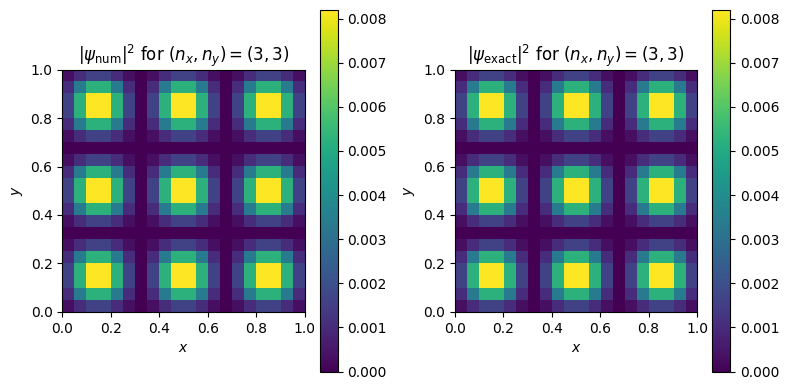

In [34]:
plot_wavefunction_pair(3,3)

**Q5.** Explain why the eigenvalues start to deviate from the analytical solution when i and j become larger.

*Write your answer to **Q5.** here*

In [22]:
def convergence_study(N_list=(8, 12, 16, 20, 24, 32)):
    """
    Study convergence of the ground-state energy E_{1,1} vs grid size N.
    Plots relative error as function of grid spacing h on a log-log scale.
    """
    E_exact = exact_energy(1, 1)

    hs = []
    errs = []

    for Ngrid in N_list:
        h = 1.0 / (Ngrid + 1)

        main = -2.0 * np.ones(Ngrid)
        off = 1.0 * np.ones(Ngrid - 1)
        L1d = sp.diags([off, main, off], [-1, 0, 1], format="csr")
        I = sp.eye(Ngrid, format="csr")
        L2d = sp.kron(I, L1d) + sp.kron(L1d, I)
        H = -L2d / (h * h)

        E0, _ = spla.eigsh(H, k=1, which="SM")
        E0 = E0[0]

        hs.append(h)
        errs.append(abs(E0 - E_exact) / E_exact)

    hs = np.array(hs)
    errs = np.array(errs)

    plt.close("Q5_conv")
    plt.figure(figsize=(5, 4), num="Q5_conv")
    plt.loglog(hs, errs, "o-", label="rel. error $E_{1,1}$")

    # reference slope ~ h^2
    ref = errs[0] * (hs / hs[0])**2
    plt.loglog(hs, ref, "--", label=r"$\propto h^2$")

    plt.gca().invert_xaxis()
    plt.xlabel("grid spacing $h$")
    plt.ylabel("relative error")
    plt.title("Convergence of ground-state energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

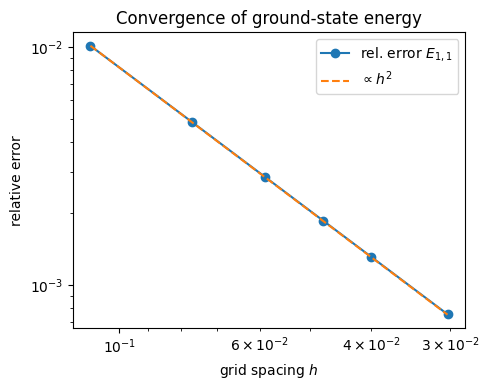

In [23]:
convergence_study()

**Q6.** The probability density functions you calculated for j,k = (1,2) and (2,1) look rotated with respect to the analytical solution. Can you explain this?

*Write your answer to **Q6.** here*

In [25]:
def degeneracy_splitting():
    """
    Inspect numerical splitting of degenerate analytic levels:
    (1,2)-(2,1), (1,3)-(3,1), (2,3)-(3,2), ...
    """
    deg_pairs = [((1, 2), (2, 1)),
                 ((1, 3), (3, 1)),
                 ((2, 3), (3, 2))]

    print("Degenerate analytic pairs and numerical splitting:")
    print("-------------------------------------------------")

    for (s1, s2) in deg_pairs:
        Eex = exact_energy(*s1)  # same as for s2

        # pick the two numerical eigenvalues closest to Eex
        idxs = np.argsort(np.abs(E_num - Eex))[:2]
        En = E_num[idxs]
        split = abs(En[0] - En[1])

        print(
            f"(nx,ny)={s1} & {s2} : "
            f"E_exact={Eex:8.4f}, "
            f"E_num≈[{En[0]:8.4f}, {En[1]:8.4f}], "
            f"ΔE={split:.3e}"
        )


In [26]:
degeneracy_splitting()

Degenerate analytic pairs and numerical splitting:
-------------------------------------------------
(nx,ny)=(1, 2) & (2, 1) : E_exact= 49.3480, E_num≈[ 49.0360,  49.0360], ΔE=5.969e-13
(nx,ny)=(1, 3) & (3, 1) : E_exact= 98.6960, E_num≈[ 97.1967,  97.1967], ΔE=6.537e-13
(nx,ny)=(2, 3) & (3, 2) : E_exact=128.3049, E_num≈[126.5302, 126.5302], ΔE=1.307e-12
